# Wildfire Model

Raster images can also be used as canvas for modeling and numerical simulation. The raster image provides a discretized spatial domain organized in rows and columns.

In this example we will use a map of the Earth's surface obtained from the NASA MODIS Terra satellite to implement a simple wildfire spread model. The model will only rely on cells that flammable (e.g. dry grassland) or non-flammable (e.g lakes), and on the wind direction. To keep it simple and demostrate the concept of using raster images as a canvas for implementing simulations, the model will not account for other variables such as the amount of fuel biomass and variable speed of the wildfire spread.

The map for this notebook is situated over the Woods county in Oklahoma and the Comanche and Barber counties in Kansas. These counties have a large area covered by natural grasslands and shrublands, and are frequently affected by large wildfires. In March of 2016, the Anderson Creek wildfire started in Oklahoma and quickly moved into Kansas burning nearly 1500 $km^2$ in just a week. The wildfire caused killed cattle, burned houses, and even bridges The burned area in Kansas was mostly in Barber and Comanche counties. The raster map was obtained just few weeks prior to this large wildfire, so that we can compare the simulated burnt area to the actual image.

Source: https://www.wikiwand.com/en/Anderson_Creek_Fire

Detailed description of MODIS bands in NASA Worldview Snapshots can be found [here](https://earthdata.nasa.gov/faq/worldview-snapshots-faq#base-layers)

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from IPython.display import clear_output


In [2]:
# Terra MODIS 7-2-1 Corrected Reflectance
# February 28, 2016 UTC
lc = xr.open_rasterio('../datasets/land_cover/anderson_creek_wildfire_2016_03_01.tiff')
lc_after = xr.open_rasterio('../datasets/land_cover/anderson_creek_wildfire_2016_04_02.tiff')


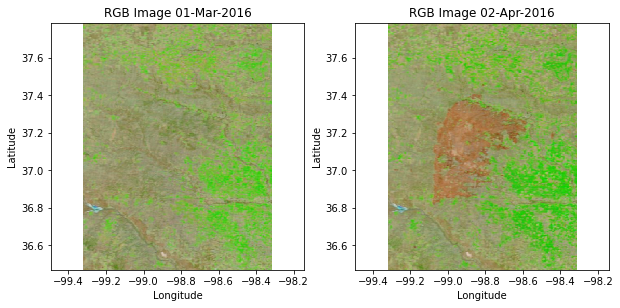

In [3]:
# Plot map
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
lc.plot.imshow(cmap='BrBG') # Band 2 contains information about vegetation
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('RGB Image 01-Mar-2016')
plt.axis('equal')

plt.subplot(2,2,2)
lc_after.plot.imshow(cmap='BrBG') # Band 2 contains information about vegetation
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('RGB Image 02-Apr-2016')
plt.axis('equal')

plt.show()

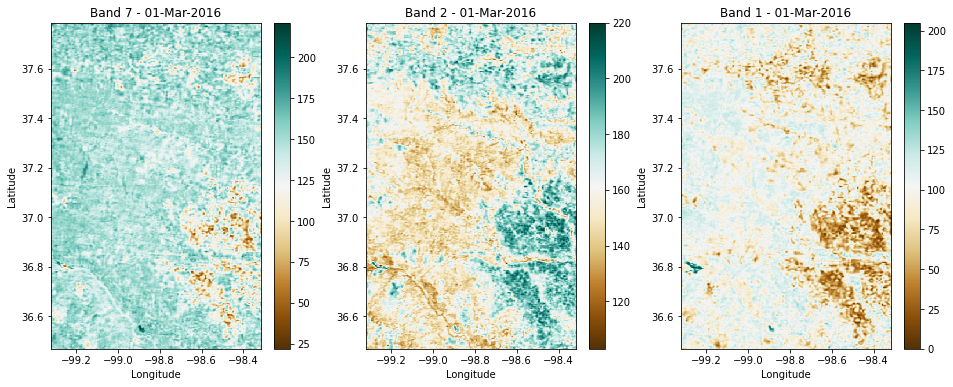

In [4]:
plt.figure(figsize=(16,6))
plt.subplot(1,3,1)

lc[0].plot.imshow(cmap='BrBG') # Band 2 contains information about vegetation
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Band 7 - 01-Mar-2016')

plt.subplot(1,3,2)
lc[1].plot.imshow(cmap='BrBG') # Band 2 contains information about vegetation
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Band 2 - 01-Mar-2016')

plt.subplot(1,3,3)
lc[2].plot.imshow(cmap='BrBG') # Band 2 contains information about vegetation
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Band 1 - 01-Mar-2016')

plt.show()

## Model premise

- Only cells with designated land covers would be able to ignite.

- Fire in a new cell can only be started by a neighboring cell currently with fire. 

- Neighboring cells will be defined using an 8-cell neighborhood array

- Wind direction will dictate which cells of the eight neighboring cell for a cell with fire will ignite next.

- Fire will propagate until the simualtion time is over.

**Land cover codes**

0 Background

24 Wheat

111 open water

121,122,123,124 developed space. Heigher the more intense

131 Barren land

141,142,143 Forests

152 Shrubland

176 Grassland/Pasture

190 Wetland

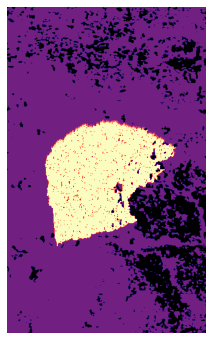

Done


In [7]:
np.random.seed(3)
start_fire = {'lat':36.82, 'lon':-99.07}

wind_coords = {'S' : np.array([0, -1]),
               'W' : np.array([1, 0]),
               'N' : np.array([0, 1]),
               'E' : np.array([-1, 0])}

wind_directions = ['N','E','S','W']
wind_prob = [0.05,0.05,0.6,0.3]

# Define array of flammable cells
# 0=non-flammable; 1=flammable but notwith fire; 2=flammable and with fire; 3=burnt

Z = lc[1]<180
Z = Z.values.astype(np.uint8) # Array to track fire dynamics.
plt.imshow(Z)
T = np.zeros(np.shape(Z)) # Matrix to keep track of ignited time

start_col = np.argmin((lc.x.values-start_fire['lon'])**2)
start_row = np.argmin((lc.y.values-start_fire['lat'])**2)
Z[start_row,start_col] = 2

# Implement model
t=0
delta_t = 1 # time span of a single iteration
P = 250
fire_residence = 2 # In terms of delta_t

while t < P:
    t += delta_t
    Znew = Z
    stop_simulation = True 
    for col in range(1,Z.shape[1]-1):
        for row in range(1,Z.shape[0]-1):  
            if Z[row,col] == 2:
                T[row,col] += delta_t
                w = np.random.choice(wind_directions, p=wind_prob)
                col_new = col + wind_coords[w][0]
                row_new = row + wind_coords[w][1]
                idx = Z[row_new,col_new] == 1; # flammable cells not ignited
                Znew[row_new[idx],col_new[idx]] = 2 # ignite cells that can be ignited
                stop_simulation = False
                if T[row,col] > delta_t*fire_residence:
                    Znew[row,col] = 3

    Z = Znew;
    clear_output(wait=True)
    plt.figure(figsize=(8,6))
    plt.imshow(Znew, cmap='magma')
    plt.axis('off')
    plt.show()
    if stop_simulation:
        break

print('Done')

## Practice

- How does the model compare with the actual Anderson Creek wildfire?

- Can you make the model to report the burnt area in real time?

- Use hourly wind speed from a weather station to drive the model.

- Implement a simple modification to account for the effect of the wind speed in the wildfire spread model.

- Download the landscape of your preference from [NASA Worldview Snapshots](https://wvs.earthdata.nasa.gov/) and re-run the simulation
